## Welcome Back Kagglers 

credit : https://www.kaggle.com/code/ammarali32/imc-2022-kornia-loftr-from-0-533-to-0-721

# ***Import dependencies***

In [1]:
"""
dry_run = False
!pip install ../input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl
!pip install ../input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl
"""

'\ndry_run = False\n!pip install ../input/kornia-loftr/kornia-0.6.4-py2.py3-none-any.whl\n!pip install ../input/kornia-loftr/kornia_moons-0.1.9-py3-none-any.whl\n'

In [2]:
import os
import numpy as np
import cv2
import csv
from glob import glob
import torch
import matplotlib.pyplot as plt
import kornia
from kornia_moons.feature import *
import kornia as K
import kornia.feature as KF
import gc
import time
import typing
import copy

from tqdm import tqdm
from collections import namedtuple
import torch

import sys
sys.path.append("../input/super-glue-pretrained-network")
from models.matching import Matching


Bad key "text.kerning_factor" on line 4 in
/home/wilmer/anaconda3/envs/p37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# ***Model***

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#LoFTR model
matcher = KF.LoFTR(pretrained=None)
matcher.load_state_dict(torch.load("loftr_outdoor.ckpt")['state_dict'])
matcher = matcher.to(device).eval()

#SuperGLUE model
config = {
    "superpoint": {
        "nms_radius": 4,
        "keypoint_threshold": 0.005,
        "max_keypoints": 1024
    },
    "superglue": {
        "weights": "outdoor",
        "sinkhorn_iterations": 20,
        "match_threshold": 0.2,
    }
}
matching = Matching(config).eval().to(device)


## *Utils*

In [4]:
#src = '../input/image-matching-challenge-2022/'
src = 'image-matching-challenge-2022'

test_samples = []
with open(f'{src}/test.csv') as f:
    reader = csv.reader(f, delimiter=',')
    for i, row in enumerate(reader):
        # Skip header.
        if i == 0:
            continue
        test_samples += [row]


def FlattenMatrix(M, num_digits=8):
    '''Convenience function to write CSV files.'''
    
    return ' '.join([f'{v:.{num_digits}e}' for v in M.flatten()])

def cv2_Torch(img: np.ndarray, device:torch.device)->torch.Tensor:
    img = K.image_to_tensor(img, False).float() /255.
    img = img.to(device)
    return img


def preprocessing_image(fname:str, device:torch.device) -> (typing.Dict[str,torch.Tensor],float):
    img = cv2.imread(fname)
    scale = 840 / max(img.shape[0], img.shape[1]) 
    w = int(img.shape[1] * scale)
    h = int(img.shape[0] * scale)
    img = cv2.resize(img, (w, h))
    
    
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    #fliped images
    imgV = cv2.flip(img, 0)
    imgH = cv2.flip(img, 1)
                        
                        
    images = {'base':img,
             'vFlipped': imgV,
             'hFlipped': imgH
             }   
    images = {k: cv2_Torch(v,device) for k, v in images.items()}
    
    return images, scale
                        
def reverseMirrorPoints(points:np.ndarray, length:typing.List[int], axis:typing.List[int]) -> np.ndarray:
    for l,a in zip(length,axis):
        points[:,a] = l - points[:,a] - 1 
    return points

def reverseRotation(points:np.ndarray, imgShape:typing.Tuple[int,int] ,clockWise:bool) -> np.ndarray:
    h,w = imgShape
    (cX, cY) = (w // 2, h // 2)
    M = (1 if clockWise else -1)*np.array([[0,1],[-1,0]])
    points = (points-[cX, cY]) @ M + [cY, cX]

    return points
                        
                        
def getLoFTRMatches(matcher:KF.LoFTR, input_dict:dict, th:float =0.4, foo = None,fooParams1:dict={},fooParams2:dict={}) -> (np.ndarray,np.ndarray):

    with torch.no_grad():
        correspondences = matcher(input_dict)
                        
    mkpts0 = correspondences['keypoints0'].cpu().numpy()
    mkpts1 = correspondences['keypoints1'].cpu().numpy()
    select = correspondences['confidence'].cpu().numpy() > th

    if foo:
        mkpts0 = foo(mkpts0[select,:],**fooParams1)
        mkpts1 = foo(mkpts1[select,:],**fooParams2)
    else:
        mkpts0 = mkpts0[select,:]
        mkpts1 = mkpts1[select,:]

    return mkpts0, mkpts1
                        
def getSuperGLUEMatches(matcher, input_dict:dict, th:float =0.4, foo = None,fooParams1:dict={},fooParams2:dict={}) -> (np.ndarray,np.ndarray):

    pred = matcher(input_dict)
    pred = {k: v[0].detach().cpu().numpy() for k, v in pred.items()}
    kpts1, kpts2 = pred["keypoints0"], pred["keypoints1"]
    matches, conf = pred["matches0"], pred["matching_scores0"]

    valid = matches > -1
    mkpts0 = kpts1[valid]
    mkpts1 = kpts2[matches[valid]]
    select = conf[valid] > th

    if foo:
        mkpts0 = foo(mkpts0[select,:],**fooParams1)
        mkpts1 = foo(mkpts1[select,:],**fooParams2)
    else:
        mkpts0 = mkpts0[select,:]
        mkpts1 = mkpts1[select,:]

    return mkpts0, mkpts1
                        
def plotMatches(image_1:torch.Tensor, image_2:torch.Tensor, mkpts0:np.ndarray, mkpts1:np.ndarray, inliers:np.ndarray):
    draw_LAF_matches(
        KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                    torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                    torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

        KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                    torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                    torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
        torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
        K.tensor_to_image(image_1),
        K.tensor_to_image(image_2),
        inliers,
        draw_dict={'inlier_color': (0.2, 1, 0.2),
                   'tentative_color': None, 
                   'feature_color': (0.2, 0.5, 1), 'vertical': False})

# ***Inference***

0


/home/wilmer/anaconda3/envs/p37/lib/python3.7/site-packages/kornia/feature/loftr/utils/coarse_matching.py:255: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/home/wilmer/anaconda3/envs/p37/lib/python3.7/site-packages/kornia/feature/loftr/utils/coarse_matching.py:258: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div

Running time:  38.46525239944458  s
1
Running time:  38.13874650001526  s
2


error: OpenCV(4.5.5) /io/opencv/modules/calib3d/src/usac/sampler.cpp:48: error: (-215:Assertion failed) sample_size <= points_size_ in function 'setPointsSize'


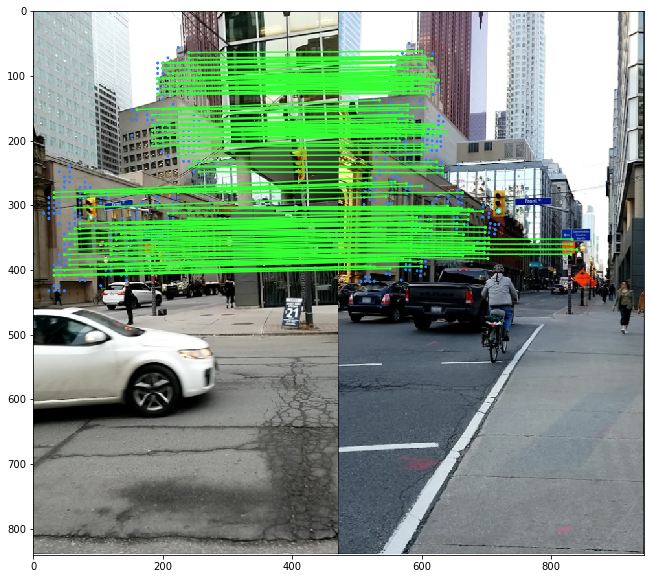

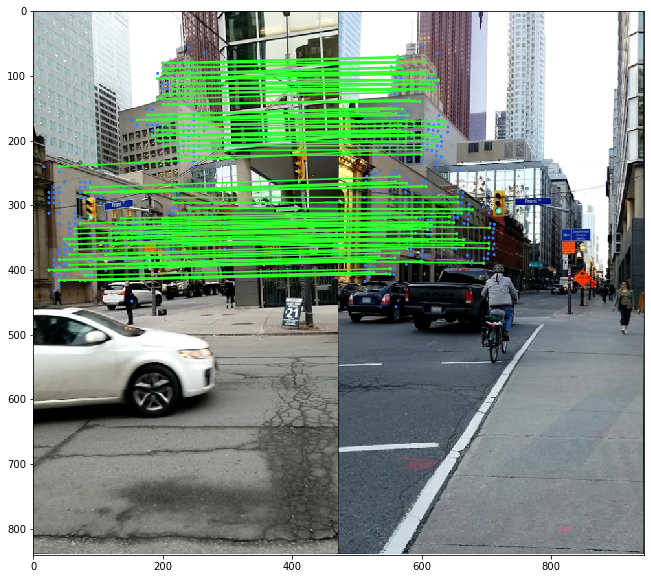

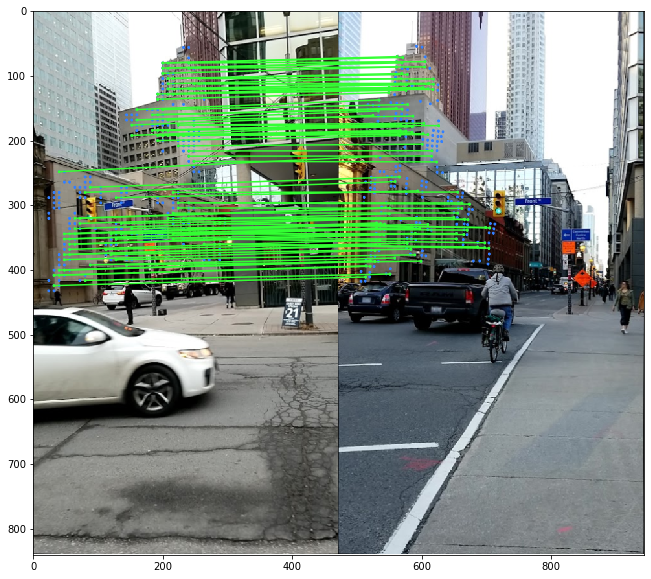

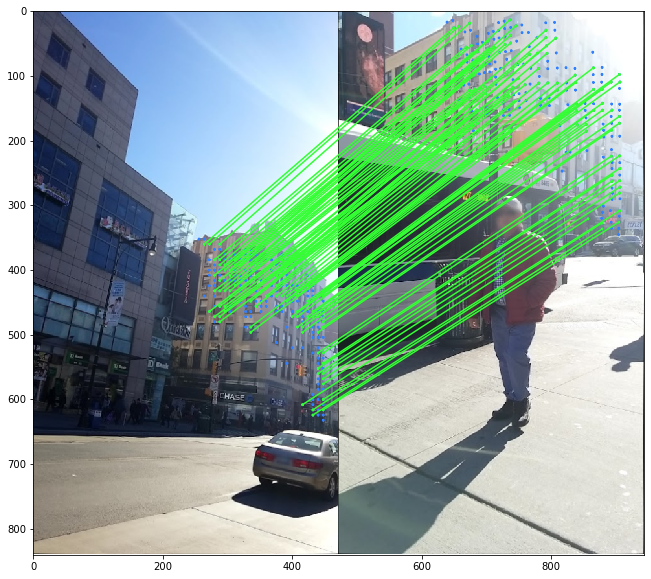

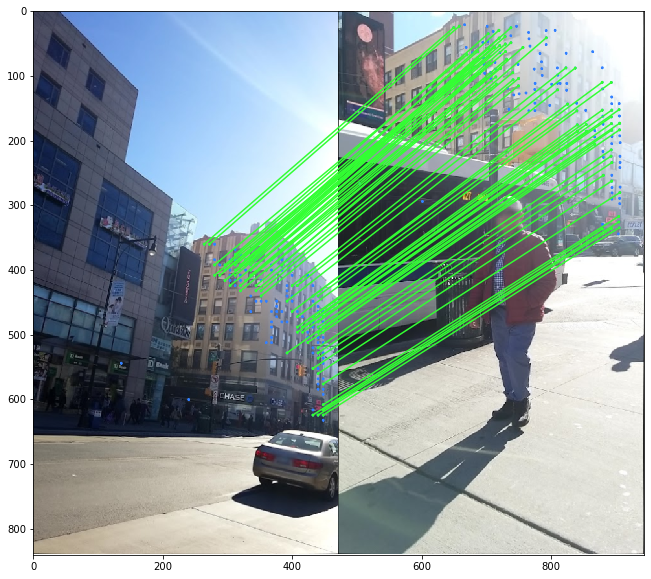

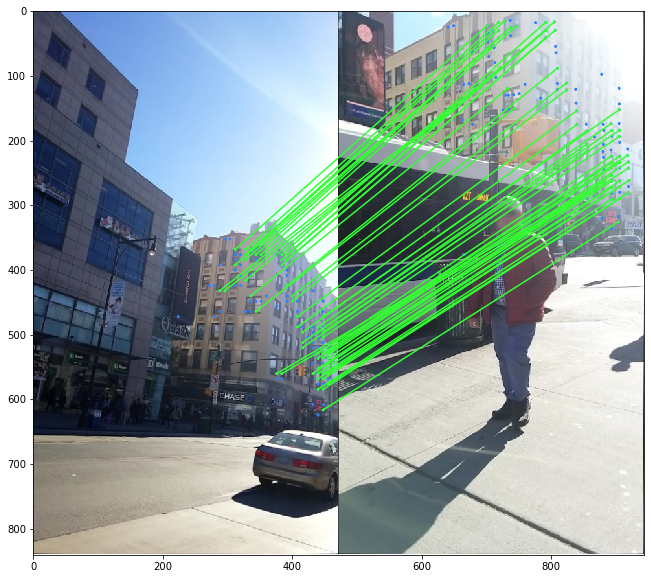

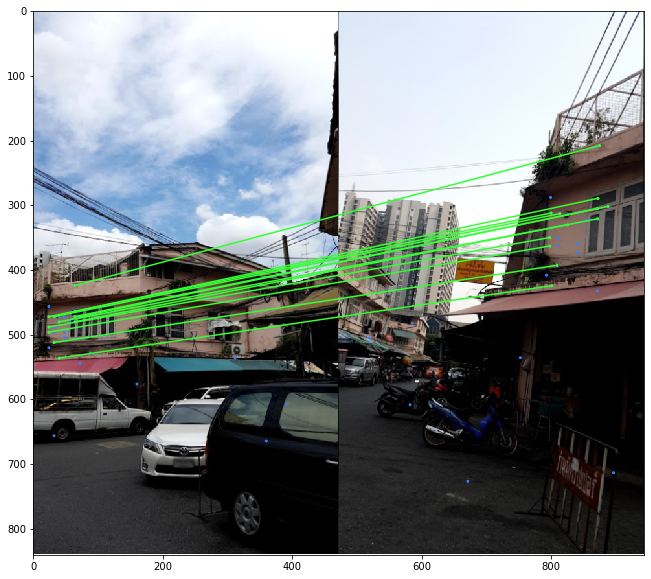

In [5]:
F_dict = {}

for i, row in enumerate(test_samples):
    print(i)
    sample_id, batch_id, image_1_id, image_2_id = row
    # Load the images.
    st = time.time()
    images1, scale1 = preprocessing_image(f'{src}/test_images/{batch_id}/{image_1_id}.png', device)
    images2, scale2 = preprocessing_image(f'{src}/test_images/{batch_id}/{image_2_id}.png', device)
    
    input_dict = {key:{"image0": K.color.rgb_to_grayscale(images1[key]),
                       "image1": K.color.rgb_to_grayscale(images2[key])} for key in images1.keys()}
    w1:int = images1['base'].shape[-1]
    h1:int = images1['base'].shape[-2]
    w2:int = images2['base'].shape[-1]
    h2:int = images2['base'].shape[-2]
    
    reverseFoo = {'base': {'foo': None},
                  'vFlipped': {'foo': reverseMirrorPoints,
                               'fooParams1': {'length':[h1],'axis':[1]},
                               'fooParams2': {'length':[h2],'axis':[1]}},
                  'hFlipped': {'foo': reverseMirrorPoints,
                               'fooParams1': {'length':[w1],'axis':[0]},
                               'fooParams2': {'length':[w2],'axis':[0]}},
                  'bFlipped': {'foo': reverseMirrorPoints,
                               'fooParams1': {'length':[w1,h1],'axis':[0,1]},
                               'fooParams2': {'length':[w2,h2],'axis':[0,1]}},
                  'rotateR': {'foo': reverseRotation,
                              'fooParams1': {'imgShape':(w1,h1) ,'clockWise': False},
                              'fooParams2': {'imgShape':(w2,h2) ,'clockWise': False}},
                  'rotateL': {'foo': reverseRotation,
                              'fooParams1': {'imgShape':(w1,h1) ,'clockWise': True},
                              'fooParams2': {'imgShape':(w2,h2) ,'clockWise': True}}
                 }
    
    mkpts = [getLoFTRMatches(matcher, v,th=0.5,**reverseFoo[k]) for k,v in input_dict.items()]
    mkpts.extend([getSuperGLUEMatches(matching, v,th=0.5,**reverseFoo[k]) for k,v in input_dict.items()])
        
    
    mkpts0 = np.empty((0,2))
    mkpts1 = np.empty((0,2))
    for points in mkpts:
        mkpts0 = np.concatenate((mkpts0, points[0]), axis=0)
        mkpts1 = np.concatenate((mkpts1, points[1]), axis=0)
    mkpts0 /= scale1
    mkpts1 /= scale2
    
    
    if len(mkpts0) > 7:   
        for i,k in enumerate(images1.keys()):
            
            F, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.1823, 0.999999, 220000)
        assert F.shape == (3, 3), 'Malformed F?'
        F_dict[sample_id] = F
    else:
        F_dict[sample_id] = np.zeros((3, 3))
        continue
    gc.collect()
    nd = time.time()    
    if (i < 3):
        print("Running time: ", nd - st, " s")

with open('submission.csv', 'w') as f:
    f.write('sample_id,fundamental_matrix\n')
    for sample_id, F in F_dict.items():
        f.write(f'{sample_id},{FlattenMatrix(F)}\n')

In [ ]:
M = cv2.getRotationMatrix2D((50, 30), 90, 1.0)

In [ ]:
M